# Main Code

## First we import all the needed libraries. I will be using Qiskit library as my primary simulator

In [1]:
from qiskit import QuantumRegister,QuantumCircuit
import numpy as np
import matplotlib
import qiskit.extensions as ex
from math import pi,sqrt
from qiskit.visualization import plot_state_city, plot_state_qsphere
from qiskit.aqua.components.optimizers import COBYLA, Optimizer
import matplotlib.pyplot as plt

In [2]:
# Getting the simulator to run the quantum circuits
from qiskit import Aer, execute
simulator = Aer.get_backend('statevector_simulator')

## Then we make the functions to apply the paramtterized gates to the quantum circuit and combine them in a function to make a layer of the quantum circuit

In [3]:
def makeOddGate(i,theta):
    '''Function to make the odd number gate in a layer
    
        inputs : i<int> : number of the gate
                 theta<np.array[float]> : the angles for the rotation gates
             
        output : qc<QuantumCircuit> : a quantum circuit with the gate appended
    '''
    
    qc = QuantumCircuit(4,name='U'+str(i))
    
    #apply the rotation gates
    for j,theta_ in enumerate(theta):
        qc.rx(theta_,j)
        
    return qc

In [4]:
def makeEvenGate(i,theta):
    '''Function to make the even number gate in a layer
    
        inputs : i<int> : number of the gate
                 theta<np.array[float]> : the angles for the rotation gates
             
        output : qc<QuantumCircuit> : a quantum circuit with the gate appended
    '''
    
    qc = QuantumCircuit(4,name='U'+str(i))
    
    # apply the rotation gates
    for j,theta_ in enumerate(theta):
        qc.rz(theta_,j)
    
    # apply the CZ gates
    for j in range(4):
        for k in range(j+1,4):
#             qc.barrier()
            qc.cz(j,k)
            
    return qc

In [5]:
def applyLayer(i,qc,theta_1,theta_2):
    '''Function to make apply a layer to the quantum cicuit
        inputs: i<int> : number of layer
                qc<QuantumCircuit> : Quantum Circuit to append the layers to
                theta_1<np.array[float]> : angle parameters for odd gate
                theta_2<np.array[float]> : angle paremeters for even gate
                
        output: qc<QuantumCircuit>: Return the appended quantum circuit    
    '''

    qc.append(makeOddGate(2*i+1,theta_1),range(4))
    qc.append(makeEvenGate(2*i+2,theta_2),range(4))
    # adding a barrier to make it easier to visualise the distinct layers
    qc.barrier()
    return qc

## Let's try to build a test circuit and see that everyting is working properly

In [6]:
# initalize a quantum circuit 
test_qc = QuantumCircuit(4)
layers = 5 #type in any number of layers

for i in range(layers):
    theta_1 = np.random.uniform(0,2*pi,4)
    theta_2 = np.random.uniform(0,2*pi,4) # testing with random parameters
    test_qc = applyLayer(i,test_qc,theta_1,theta_2)

## Lets draw the resulting circuit

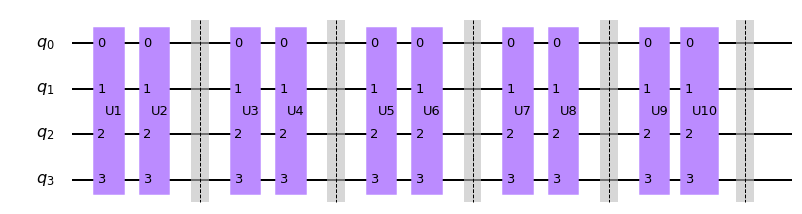

In [7]:
test_qc.draw('mpl')

## Now lets draw the circuit with individual gates

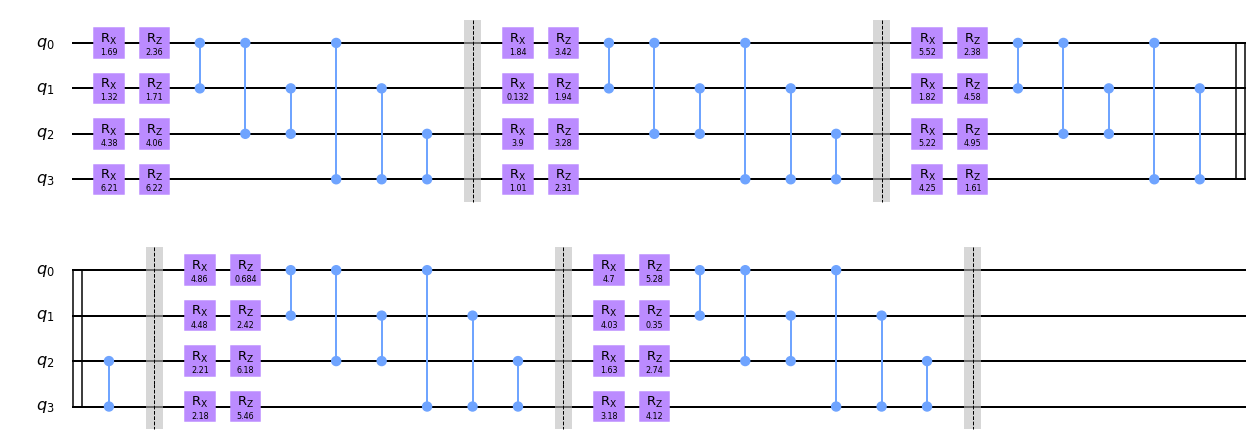

In [8]:
test_qc.decompose().draw('mpl')

## Everything looks good. Now let's build the code for minimizing

The distance function between random state( $|\varphi\rangle$) and the obtained statevector $|\psi(\theta)\rangle$ is given by -

$$\epsilon = |||\psi(\theta)\rangle - |\varphi\rangle||$$

where, $|||\nu\rangle||$ is the norm of the state $|\nu\rangle$. We need to minimize this $\epsilon$ over the parameter $\theta$.


In [9]:
def funcToMin(theta,layers,rand_state_vector):
    '''
    Function to be minimized. It creates a circuit based on the given parameters and 
    runs the simulator to get the final statevector. It then caculates the distance 
    between the obtained state vector and the random state vector.
    
    inputs: theta<np.array[float]>: The array of angles for parametrization of gates
            layers<int>: no of layers to apply to the quantum circuit
            rand_state_vector<np.array[complex[float]]: random state vector to calculate the distance from
    
    output: distance<float> : the calculated value of the distance between the obtained 
                              state and the random state.
    '''
    # initializing a quantum register and circuit
    reg = QuantumRegister(4)
    qc = QuantumCircuit(reg)
        
    for i in range(layers):
        theta_1 = theta[(8*i):(8*i)+4]
        theta_2 = theta[(8*i)+4:(8*i)+8] # getting parameters for a particular gate from the universal parameters
        qc = applyLayer(i,qc,theta_1,theta_2)
        
    #running the simulataor and getting the statevector
    result = execute(qc,simulator).result()
    statevector = result.get_statevector(qc)

    
    return sqrt(sum(abs(statevector - rand_state_vector)**2))

## Now that all the helper functions are done, lets write the script for the minmization.

I am using the COBYLA(Constrained Optimization By Linear Approximation) optimizer included with the qiskit library(also included in nlopt library) to do the minimization. I am choosing this because this is a derivative free method and preferred for noise free sutiations such as this(according to the qiskit manual on optimizers used in VQE). A deravite free medthod is desirable beaucause we do not have an simple analytic expression for the cost function(function to be minimized).

In [10]:
# Define the number of layers we want the minimum distance plot for
layers = 10

# Define a random state vector
rand_state_vector = np.random.rand(2**4) + 1j*np.random.rand(2**4)
rand_state_vector = rand_state_vector/sqrt(sum(abs(rand_state_vector)**2))

# Get an instance of the optimizer
optimizer = COBYLA(maxiter = 2000)


x_axis = []
y_axis = []

# run the optiizer for all the layers leading up to the final number of layers
for i in range(layers):  
    print("working on layer: {}".format(i+1))
    cost_func = COBYLA.wrap_function(funcToMin,(i+1,rand_state_vector)) # wrapping the distance function to 
                                                                        # accept additional arguments
    result = optimizer.optimize((i+1)*8,cost_func, initial_point = np.random.uniform(0,2*pi,8*(i+1)))
    x_axis.append(i+1)
    y_axis.append(result[1])
    print('Minimum distance obtained: '+str(result[1]))

working on layer: 1
Minimum distance obtained: 0.776728697650301
working on layer: 2
Minimum distance obtained: 0.30420205286547464
working on layer: 3
Minimum distance obtained: 0.24549028799676187
working on layer: 4
Minimum distance obtained: 0.197807993694933
working on layer: 5
Minimum distance obtained: 0.15936820033995097
working on layer: 6
Minimum distance obtained: 0.04981441348118612
working on layer: 7
Minimum distance obtained: 0.07519206848068534
working on layer: 8
Minimum distance obtained: 0.07021641654487888
working on layer: 9
Minimum distance obtained: 0.04886413057574261
working on layer: 10
Minimum distance obtained: 0.06760589897793787


## Now we can plot the min distance vs L graph

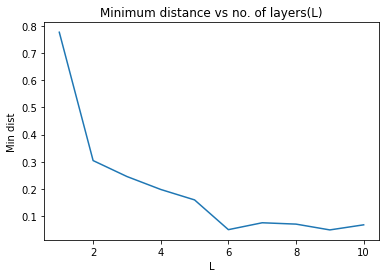

In [11]:
plt.plot(x_axis,y_axis)
plt.title('Minimum distance(Min dist) vs no. of layers(L)')
plt.ylabel('Min dist')
plt.xlabel('L')
plt.show()

# Observations

As is seen from the graph, the minimum distance decreases consistently with increasing number of layers applied.

This particuar circuit seems to be able to get close to any random state vector given the correct parameters($\theta s$ in this case). There are some random spikes when the minimum distance starts going below 0.01, but I think these are the limitations of the mimimizing function used as the graph shows a constistent convergence except for these random anomalies. The graph reaches a convergence with incresing number of layers.

*Technically the parameters lie between 0 and $2\pi$, since they are angles, but the COBYLA function in qiskit does not support variable bounds(according to the documentation). Although since the gates should be cyclic in $\theta$, it might should not affect the output much.

# Bonus Task

We can try the same procedure with different parametrized gates. Like for example RY gate.

## Lets start by replacing RX gates with RY. For this we need to redefine the function for building odd gates.

In [12]:
def makeOddGate(i,theta):
    '''Function to make the odd number gate in a layer
    
        inputs : i<int> : number of the gate
                 theta<np.array[float]> : the angles for the rotation gates
             
        output : qc<QuantumCircuit> : a quantum circuit with the gate appended
    '''
    
    qc = QuantumCircuit(4,name='U'+str(i))
    
    #replacing rx gates with ry
    for j,theta_ in enumerate(theta):
        qc.ry(theta_,j)
        
    return qc

In [13]:
def makeEvenGate(i,theta):
    '''Function to make the even number gate in a layer
    
        inputs : i<int> : number of the gate
                 theta<np.array[float]> : the angles for the rotation gates
             
        output : qc<QuantumCircuit> : a quantum circuit with the gate appended
    '''
    
    qc = QuantumCircuit(4,name='U'+str(i))
    
    # apply the rotation gates
    for j,theta_ in enumerate(theta):
        qc.rz(theta_,j)
    
    # apply the CZ gates
    for j in range(4):
        for k in range(j+1,4):
#             qc.barrier()
            qc.cz(j,k)
            
    return qc

## Lets test with a test quantum circuit and check that the circuit is right

In [14]:
# initalize a quantum circuit 
test_qc = QuantumCircuit(4)
layers = 5 #type in any number of layers

for i in range(layers):
    theta_1 = np.random.uniform(0,2*pi,4)
    theta_2 = np.random.uniform(0,2*pi,4) # testing with random parameters
    test_qc = applyLayer(i,test_qc,theta_1,theta_2)

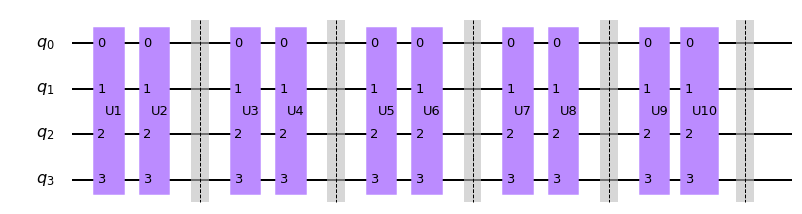

In [15]:
test_qc.draw('mpl')

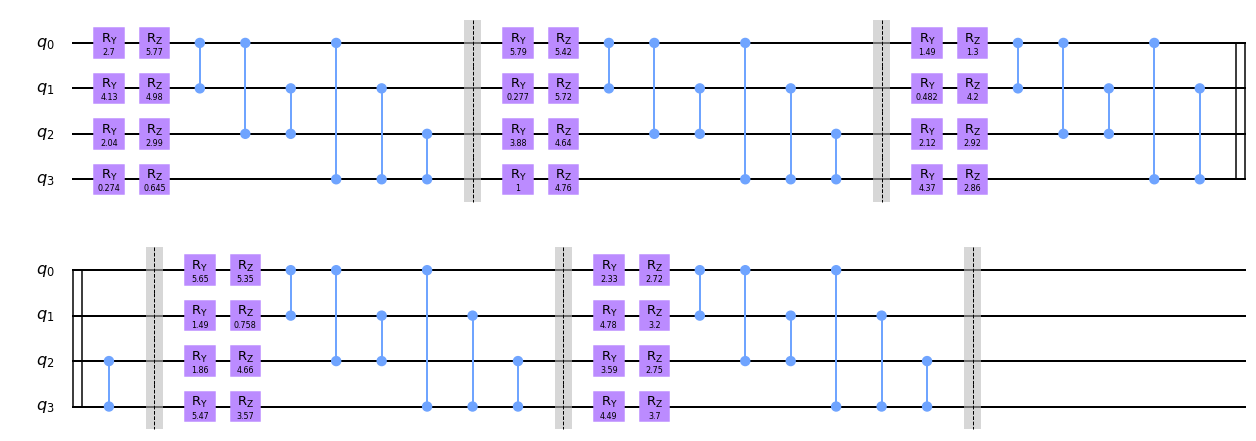

In [17]:
test_qc.decompose().draw('mpl')

## Eyerything looks good. Lets try to run the optimizer for it.

In [18]:
# Define the number of layers we want the minimum distance plot for
layers = 10

# Define a random state vector
rand_state_vector = np.random.rand(2**4) + 1j*np.random.rand(2**4)
rand_state_vector = rand_state_vector/sqrt(sum(abs(rand_state_vector)**2))

# Get an instance of the optimizer
optimizer = COBYLA(maxiter = 2000)


x_axis = []
y_axis = []

# run the optiizer for all the layers leading up to the final number of layers
for i in range(layers):  
    print("working on layer: {}".format(i+1))
    cost_func = COBYLA.wrap_function(funcToMin,(i+1,rand_state_vector)) # wrapping the distance function to 
                                                                        # accept additional arguments
    result = optimizer.optimize((i+1)*8,cost_func, initial_point = np.random.uniform(0,2*pi,8*(i+1)))
    x_axis.append(i+1)
    y_axis.append(result[1])
    print('Minimum distance obtained: '+str(result[1]))

working on layer: 1
Minimum distance obtained: 0.8005094751576497
working on layer: 2
Minimum distance obtained: 0.26102830701175467
working on layer: 3
Minimum distance obtained: 0.19207603642111307
working on layer: 4
Minimum distance obtained: 0.09177621119375434
working on layer: 5
Minimum distance obtained: 0.06998030651513132
working on layer: 6
Minimum distance obtained: 0.18403953438904616
working on layer: 7
Minimum distance obtained: 0.0428777976064048
working on layer: 8
Minimum distance obtained: 0.051084955002631625
working on layer: 9
Minimum distance obtained: 0.03789798972922921
working on layer: 10
Minimum distance obtained: 0.03736117728057994


## Now we plot the graph

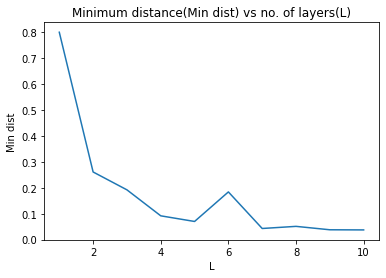

In [19]:
plt.plot(x_axis,y_axis)
plt.title('Minimum distance(Min dist) vs no. of layers(L)')
plt.ylabel('Min dist')
plt.xlabel('L')
plt.show()

## Observation

The graph also seems to converge for this particular sets of gates. The spike on this is more noticable than the previous sets, but it still seems to converge to below .05 distance like the RX and RZ set. The minimum distance on this one is lower on this set of gates (.037) compared to the .048 on the last set. The plot also seems to converge a lille bit faster on this.

## We can also try the set of RX and RY by replacing the RZ gate with RY.

In [20]:
def makeOddGate(i,theta):
    '''Function to make the odd number gate in a layer
    
        inputs : i<int> : number of the gate
                 theta<np.array[float]> : the angles for the rotation gates
             
        output : qc<QuantumCircuit> : a quantum circuit with the gate appended
    '''
    
    qc = QuantumCircuit(4,name='U'+str(i))
    
    #applying rotation gates
    for j,theta_ in enumerate(theta):
        qc.rx(theta_,j)
        
    return qc

In [21]:
def makeEvenGate(i,theta):
    '''Function to make the even number gate in a layer
    
        inputs : i<int> : number of the gate
                 theta<np.array[float]> : the angles for the rotation gates
             
        output : qc<QuantumCircuit> : a quantum circuit with the gate appended
    '''
    
    qc = QuantumCircuit(4,name='U'+str(i))
    
    # replacing rz gate with ry
    for j,theta_ in enumerate(theta):
        qc.ry(theta_,j)
    
    # apply the CZ gates
    for j in range(4):
        for k in range(j+1,4):
#             qc.barrier()
            qc.cz(j,k)
            
    return qc

## Testing with a quantum circuit 

In [22]:
# initalize a quantum circuit 
test_qc = QuantumCircuit(4)
layers = 5 #type in any number of layers

for i in range(layers):
    theta_1 = np.random.uniform(0,2*pi,4)
    theta_2 = np.random.uniform(0,2*pi,4) # testing with random parameters
    test_qc = applyLayer(i,test_qc,theta_1,theta_2)

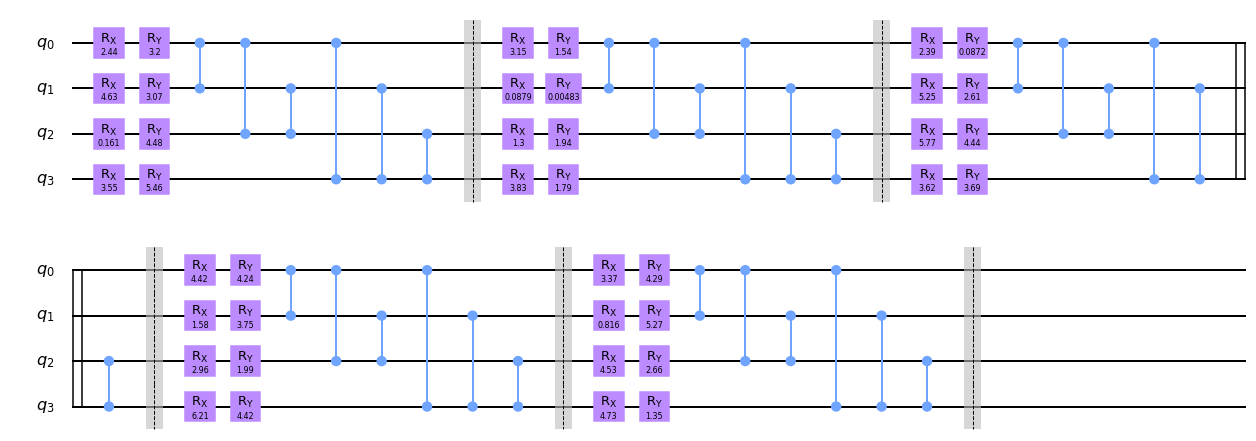

In [24]:
test_qc.decompose().draw('mpl')

##  Lets run the optimizer

In [26]:
# Define the number of layers we want the minimum distance plot for
layers = 10

# Define a random state vector
rand_state_vector = np.random.rand(2**4) + 1j*np.random.rand(2**4)
rand_state_vector = rand_state_vector/sqrt(sum(abs(rand_state_vector)**2))

# Get an instance of the optimizer
optimizer = COBYLA(maxiter = 2000)


x_axis = []
y_axis = []

# run the optiizer for all the layers leading up to the final number of layers
for i in range(layers):  
    print("working on layer: {}".format(i+1))
    cost_func = COBYLA.wrap_function(funcToMin,(i+1,rand_state_vector)) # wrapping the distance function to 
                                                                        # accept additional arguments
    result = optimizer.optimize((i+1)*8,cost_func, initial_point = np.random.uniform(0,2*pi,8*(i+1)))
    x_axis.append(i+1)
    y_axis.append(result[1])
    print('Minimum distance obtained: '+str(result[1]))

working on layer: 1
Minimum distance obtained: 1.1349192430099273
working on layer: 2
Minimum distance obtained: 0.6939519132429517
working on layer: 3
Minimum distance obtained: 0.29056640960814056
working on layer: 4
Minimum distance obtained: 0.44699790273081474
working on layer: 5
Minimum distance obtained: 0.10067396368924321
working on layer: 6
Minimum distance obtained: 0.10252795767965936
working on layer: 7
Minimum distance obtained: 0.048122971508225844
working on layer: 8
Minimum distance obtained: 0.09512872861900866
working on layer: 9
Minimum distance obtained: 0.16480755320026136
working on layer: 10
Minimum distance obtained: 0.17359358497207455


## Plotting the graph

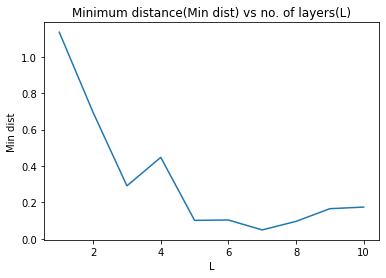

In [27]:
plt.plot(x_axis,y_axis)
plt.title('Minimum distance(Min dist) vs no. of layers(L)')
plt.ylabel('Min dist')
plt.xlabel('L')
plt.show()

## Observation

This one does not seem to converge as well as the last two. The distance mostly stayed above 0.1 and did not go below 0.48. Based on the observations so far, the gate combination of RY and RZ seems to work the best closely followed by the set of RX and RZ, with the RX and RY combination performing the worst of the lot.